# Install libraries

In [1]:
!pip install gym==0.25.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.5/734.5 kB 11.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.25.2-py3-none-any.whl size=852300 sha256=1b3b4d77d3aa265831887ca956970a6f1acc6c46a661df56143110d63cc96a5e
  Stored in directory: /root/.cache/pip/wheels/78/95/2c/ee47a8d43fda6a851e340e77e27cf75b49ff4ce2d1540c0e80
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2


In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
#!pip install colabgymrender==1.0.2
!pip install "gym[atari, accept-rom-license]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 22.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=94884cfce0874df817b13d31635b074b2fd556c84d1ed61f0c729698ab7ace64
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [3]:
import gym
import cv2
import math
import random
import warnings
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

In [4]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

#Preprocess

In [6]:
def preprocess(state):
#     state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
#     state_resize = cv2.resize(state, (84, 84), interpolation=cv2.INTER_CUBIC)
#     state_resize = np.reshape(state_resize, (1, 84, 84))

#     return state_resize
    # Convert to grayscale
    state_gray = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)

    # Resize
    state_resize = cv2.resize(state_gray, (84, 84), interpolation=cv2.INTER_CUBIC)
    

    # Reshape
    tensor_image = transforms.ToTensor()(state_resize).numpy()

    return tensor_image


# Replay buffer

In [7]:
class ReplayMemory():
    def __init__(self, max_size, min_replay_size):
        self.max_size = max_size
        self.memory = deque(maxlen=self.max_size)
        self.min_replay_size = min_replay_size

    def add(self, experience):
        state, action, reward, done, next_state = experience
        state = preprocess(state) # resize and convert to gray scale
        next_state = preprocess(next_state) # resize and convert to gray scale
        experience = (state, action, reward, done, next_state)
        self.memory.append(experience)

    def get_batch(self, batch_size):
        experiences = random.sample(self.memory, batch_size)

        # Take batches from experiences
        states = np.array([experience[0] for experience in experiences])
        actions = np.array([experience[1] for experience in experiences])
        rewards = np.array([experience[2] for experience in experiences])
        dones = np.array([experience[3] for experience in experiences])
        next_states = np.array([experience[4] for experience in experiences])

        # Convert to tensor
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        dones = torch.tensor(dones, dtype=torch.float32).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)

        return states, actions, rewards, dones, next_states


In [8]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        # set common feature layer
        self.feature_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_dim, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # set advantage layer
        self.advantage_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=11552, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=out_dim)
        )

        # set value layer
        self.value_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=11552, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        feature = self.feature_layer(x)

        value = self.value_layer(feature)
        advantage = self.advantage_layer(feature)

        q = value + advantage - advantage.mean(dim=-1, keepdim=True)

        return q

    def choose_action(self, state):
        # Compute max q value
        state = preprocess(state)
        state = torch.tensor(state, dtype=torch.float32).to(device)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

# Agent

In [9]:
class DuelingDQNAgent():
    def __init__(self, env, max_epsilon, min_epsilon, max_num_steps, \
                 epsilon_decay_intervals, gamma, alpha, \
                 memory_size, min_replay_size, batch_size, \
                 target_update_frequency):
        # Environment
        self.env = env
        # Memory replay
        self.memory = ReplayMemory(max_size=memory_size, min_replay_size=min_replay_size)

        # Hyperparameters
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.max_num_steps = max_num_steps
        self.epsilon_decay_intervals = epsilon_decay_intervals
        self.gamma = gamma # discount value
        self.alpha = alpha # learning rate
        self.batch_size = batch_size # batch size taken from memory
        self.target_update_frequency = target_update_frequency # target network update frequency

        # Network
        self.q_net = Network(1, self.env.action_space.n).to(device)
        self.target_net = Network(1, self.env.action_space.n).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=self.alpha)

    def choose_action(self, epsilon, state):
        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = self.env.action_space.sample()
        else:
            action = self.q_net.choose_action(state)
        return action

    def fill_memory(self):
        state = self.env.reset()

        # Loop min_replay_size times and append experience to memory
        for _ in range(self.memory.min_replay_size):

            # Randomly taking action
            action = self.env.action_space.sample()

            next_state, reward, done, info = self.env.step(action)
            experience = (state, action, reward, done, next_state)

            # Add to memory
            self.memory.add(experience)

            state = next_state

            if done:
                self.env.reset()

    def training(self):
        # Fill memory
        self.fill_memory()
        reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

        reward_per_episode = 0.0
        state = self.env.reset()
        all_rewards = []

        for step in range(self.max_num_steps):
            # Computer epsilon
            epsilon = np.interp(step, [0, self.epsilon_decay_intervals], [self.max_epsilon, self.min_epsilon])
            # Choose action to take
            action = self.choose_action(epsilon, state)

            # Take action and add experience to memory
            next_state, reward, done, info = self.env.step(action)
            experience = (state, action, reward, done, next_state)
            # Add to memory
            self.memory.add(experience)

            reward_per_episode += reward

            state = next_state

            # If done, 1 episode is done
            if done:
                state = self.env.reset()
                reward_buffer.append(reward_per_episode)
                all_rewards.append((step, reward_per_episode))
                reward_per_episode = 0.0

            states, actions, rewards, dones, next_states = self.memory.get_batch(self.batch_size)

            # Predict Q value with Q network
            q_values = self.q_net(states)
            action_q_values = torch.gather(input=q_values, dim=1, index=actions)

            # Predict target with Target network
            # Compute targets using the formulation sample = r + gamma * max q(s',a')
            target_q_values = self.target_net(next_states)
            max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
            targets = rewards + self.gamma * (1 - dones) * max_target_q_values

            # Compute loss
            loss = torch.nn.functional.mse_loss(action_q_values, targets)

            # Gradient descent for q-network
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Update target network
            if (step + 1) % self.target_update_frequency == 0:
                self.target_net.load_state_dict(self.q_net.state_dict())

            # Print training results
            if (step + 1) % 1000 == 0:
                average_reward = np.mean(reward_buffer)
                print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')
        return all_rewards

In [41]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 500000
epsilon_decay_intervals = 100000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

# Memory
memory_size = 35000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [42]:
# environment
env = gym.make("ALE/KungFuMaster-v5")

In [43]:
# train
agent = DuelingDQNAgent(env, max_epsilon, min_epsilon, max_num_steps,
                 epsilon_decay_intervals, gamma, alpha,
                 memory_size, min_replay_size, batch_size,
                 target_update_frequency)

In [44]:
begin = time.time()
all_rewards = agent.training()
print(f"Training time: {time.time()-begin}")

Episode: 1 Step: 1000 Average reward: 0.0
Episode: 2 Step: 2000 Average reward: 300.0
Episode: 3 Step: 3000 Average reward: 200.0
Episode: 4 Step: 4000 Average reward: 325.0
Episode: 5 Step: 5000 Average reward: 380.0
Episode: 6 Step: 6000 Average reward: 550.0
Episode: 7 Step: 7000 Average reward: 528.5714285714286
Episode: 8 Step: 8000 Average reward: 512.5
Episode: 9 Step: 9000 Average reward: 500.0
Episode: 10 Step: 10000 Average reward: 510.0
Episode: 11 Step: 11000 Average reward: 518.1818181818181
Episode: 12 Step: 12000 Average reward: 500.0
Episode: 13 Step: 13000 Average reward: 500.0
Episode: 13 Step: 14000 Average reward: 500.0
Episode: 15 Step: 15000 Average reward: 560.0
Episode: 16 Step: 16000 Average reward: 531.25
Episode: 17 Step: 17000 Average reward: 517.6470588235294
Episode: 17 Step: 18000 Average reward: 517.6470588235294
Episode: 19 Step: 19000 Average reward: 515.7894736842105
Episode: 19 Step: 20000 Average reward: 515.7894736842105
Episode: 20 Step: 21000 Ave

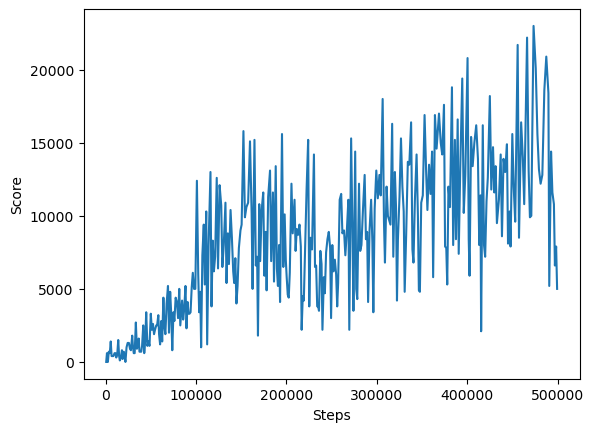

In [45]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [46]:
torch.save(agent.q_net.state_dict(), "./dueling_DQN_500k")

In [38]:
t_model = Network(1, env.action_space.n).to(device)
t_model.load_state_dict(torch.load("./dueling_DQN_500k"))

<All keys matched successfully>

In [39]:
#env = Recorder(env, './video')
while True:
    state = env.reset()
    done = False
    total_reward = 0.0

    t_model.eval()

    with torch.no_grad():
        while not done:
            action = t_model.choose_action(state)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            state = next_state

    print(total_reward)
#env.play()

15300.0
9700.0
8200.0
15700.0
17400.0
13000.0
17200.0
12800.0
6400.0
17200.0
16900.0
12600.0
16000.0
8800.0
10200.0
10200.0
17000.0
7600.0
13700.0
8200.0
17400.0
10800.0
9600.0
6300.0
10700.0
10000.0
17800.0
10000.0
18700.0
8000.0
6700.0
13000.0
5800.0
16000.0
13000.0
8800.0
12600.0
12500.0
9000.0
8800.0
16000.0
10400.0
10000.0
5400.0
13900.0
9400.0
10800.0
12000.0
15600.0
8900.0
10800.0
19200.0
12400.0
18200.0
13200.0
6000.0
12100.0
8800.0
11000.0
14400.0
18000.0
13500.0
9900.0
10400.0
16200.0
6000.0
9900.0
13000.0
8800.0
11800.0
15200.0
19000.0
9400.0
20100.0
9400.0
13200.0
19400.0
12200.0


KeyboardInterrupt: 

In [47]:
np.save('./dueling_DQN_rewards_500k.npy',all_rewards)

In [ ]:
s = np.load('/content/drive/MyDrive/dueling_DQN_rewards_200k.npy')

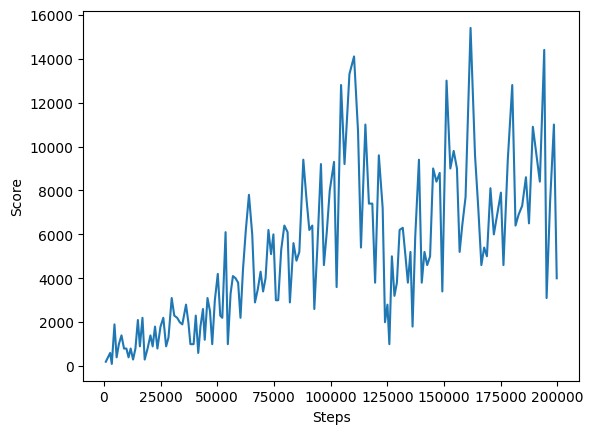

In [ ]:
s = np.array(s)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(s[:, 0],s[:, 1])

In [ ]:
# train
new_agent = DuelingDQNAgent(env, max_epsilon, min_epsilon, max_num_steps,
                 epsilon_decay_intervals, gamma, alpha,
                 memory_size, min_replay_size, batch_size,
                 target_update_frequency, "Continue")

In [ ]:
new_all_rewards = new_agent.training()

Episode: 1 Step: 1000 Average reward: 200.0


KeyboardInterrupt: ignored